In [1]:
import numpy as np, pandas as pd, time, os, itertools, subprocess, scipy as sp, re
import seaborn; seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt, importlib
import scipy.sparse
import utils, diffmap as dm#, scanpy as sc
import sklearn.metrics

data_pfx = '/oak/stanford/groups/akundaje/abalsubr/search_ui/'

In [5]:
importlib.reload(utils)


<module 'utils' from '/users/abalsubr/encode-ui-sandbox/utils.py'>

# Experimental embeddings

In [6]:
itime = time.time()
eemb = np.load(data_pfx + 'avocado_model/experiment_embedding.npz')['arr_0']
print(time.time() - itime)
sparse_adj = utils.make_nn_graph(eemb, k=10)
print(time.time() - itime)

0.1419386863708496
5.411322832107544


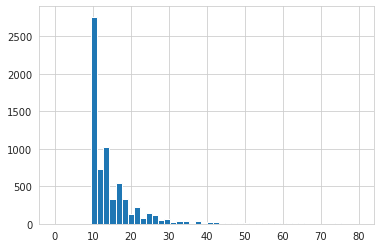

In [9]:
#scipy.sparse.save_npz(data_pfx + 'encode3_6870_10nn.npz', sparse_adj)
plt.hist(np.ravel(sparse_adj.sum(axis=0)), bins=50, range=(0,80))
plt.show()

# Read avocado embeddings

In [6]:
import numpy
from tqdm import tqdm

experiments = numpy.loadtxt("data/ENCODE_Tracks.txt", delimiter='\t', dtype=str)
celltypes = list(numpy.unique(experiments[:,0]))
assays = list(numpy.unique(experiments[:,1]))

# real_data = load_datasets(experiments, '/net/noble/vol5/user/jmschr/proj/ENCODE/')
# imputed_data = data = load_datasets(experiments, '/tmp/jmschr/')

# real_corr = numpy.corrcoef(real_data).astype('float32')
# imputed_corr = numpy.corrcoef(imputed_data).astype('float32')

# numpy.savez_compressed("real_correlations_3150_600000.npz", real_corr)
# numpy.savez_compressed("imputed_correlations_3150_600000.npz", imputed_corr)

In [7]:
experiments

array([['J000', 'ChIP-seq_H3K79me2_signal_p-value'],
       ['J002', 'CAGE_plus_strand_signal_of_all_reads'],
       ['J006', 'polyA_RNA-seq_minus_strand_signal_of_all_reads'],
       ...,
       ['J221', 'ChIP-seq_H3K9me3_signal_p-value'],
       ['J382', 'polyA_RNA-seq_plus_strand_signal_of_all_reads'],
       ['J223', 'ChIP-seq_H3K9me3_signal_p-value']], dtype='<U55')